In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## Looking at Individual Payer 417614
### v1.1

In [2]:
#Shamelessly lifted from Jon's branch
bridge = pd.read_csv("../data/bridge.csv")
dim_claims = pd.read_csv("../data/dim_claims.csv")
dim_date = pd.read_csv("../data/dim_date.csv")
dim_pa = pd.read_csv("../data/dim_pa.csv")

In [3]:
df2 = bridge.merge(dim_claims, on='dim_claim_id', how='left').copy()
df4 = df2.merge(dim_pa, on='dim_pa_id', how='left').copy()

df4.head(10)
df4[df4.bin == 417614].head(25)

,dim_claim_id,dim_pa_id,dim_date_id,bin,drug,reject_code,pharmacy_claim_approved,correct_diagnosis,tried_and_failed,contraindication,pa_approved
14,15,5.0,1,417614,A,70.0,0,0.0,1.0,0.0,1.0
15,16,6.0,1,417614,A,70.0,0,1.0,1.0,0.0,1.0
17,18,7.0,1,417614,A,70.0,0,0.0,1.0,0.0,1.0
19,20,8.0,1,417614,A,70.0,0,1.0,0.0,1.0,0.0
20,21,9.0,1,417614,A,70.0,0,1.0,0.0,1.0,0.0
21,22,10.0,1,417614,A,70.0,0,1.0,1.0,0.0,1.0
22,23,11.0,1,417614,A,70.0,0,1.0,1.0,1.0,1.0
27,28,12.0,1,417614,A,70.0,0,1.0,1.0,0.0,0.0
28,29,13.0,1,417614,A,70.0,0,1.0,0.0,1.0,0.0
29,30,14.0,1,417614,A,70.0,0,1.0,1.0,0.0,0.0


In [4]:
mypayer=df4[df4.bin == 417614].copy()

In [5]:
mypayer = mypayer.fillna(-1)
mypayer.shape

(307323, 11)

In [6]:
mypayer.head(10)
#mypayer.reject_code == -1

,dim_claim_id,dim_pa_id,dim_date_id,bin,drug,reject_code,pharmacy_claim_approved,correct_diagnosis,tried_and_failed,contraindication,pa_approved
14,15,5.0,1,417614,A,70.0,0,0.0,1.0,0.0,1.0
15,16,6.0,1,417614,A,70.0,0,1.0,1.0,0.0,1.0
17,18,7.0,1,417614,A,70.0,0,0.0,1.0,0.0,1.0
19,20,8.0,1,417614,A,70.0,0,1.0,0.0,1.0,0.0
20,21,9.0,1,417614,A,70.0,0,1.0,0.0,1.0,0.0
21,22,10.0,1,417614,A,70.0,0,1.0,1.0,0.0,1.0
22,23,11.0,1,417614,A,70.0,0,1.0,1.0,1.0,1.0
27,28,12.0,1,417614,A,70.0,0,1.0,1.0,0.0,0.0
28,29,13.0,1,417614,A,70.0,0,1.0,0.0,1.0,0.0
29,30,14.0,1,417614,A,70.0,0,1.0,1.0,0.0,0.0


Do we have any cases where the drug is rejected, but a PA is not requested? The code below demonstrates we do not.

In [7]:
min(mypayer[(mypayer.pharmacy_claim_approved == 0)].dim_pa_id)

5.0

In [8]:
#X = mypayer.drop(columns='pa_approved').copy()
#X.head()
#y = mypayer['pa_approved'].copy()
#y.head(5)


Now, to tackle the question "If a PA is required which features on the PA claim (Correct diagnosis, Tried and failed, Contraindication) help get the PA approved?"

Given what we found above, all or nearly all of the code 75 rejections should be approved with a PA

In [9]:
pa = mypayer[mypayer.pharmacy_claim_approved == 0].copy()
y = pa['pa_approved']

X_train,X_test,y_train,y_test = train_test_split(pa,y,
                                                 test_size = .25,
                                                 random_state = 614,
                                                 shuffle = True,
                                                 stratify = y)

#X_train.head(10)
codes = X_train['reject_code'].unique()
print(codes)
#X_train = X_train[X_train.pharmacy_claim_approved == 0]
#y_train = X_train['pa_approved']


for code in codes:
    if(code != -1): 
        pa_approved = X_train[(X_train.reject_code == code) & (y_train == 1)].shape[0]
        pa_req = X_train[(X_train.reject_code == code) & (X_train.dim_pa_id > 0)].shape[0]
        if(pa_req == 0): 
            app_rate = -99
        else:
            app_rate = pa_approved/pa_req
        print("Reject Code ",code,"has approval rate of ",app_rate)

[70. 75. 76.]
Reject Code  70.0 has approval rate of  0.5817332685637341
Reject Code  75.0 has approval rate of  0.973280051475693
Reject Code  76.0 has approval rate of  0.6401508011310085


In [10]:
X_train.head()


,dim_claim_id,dim_pa_id,dim_date_id,bin,drug,reject_code,pharmacy_claim_approved,correct_diagnosis,tried_and_failed,contraindication,pa_approved
818988,818989,340465.0,712,417614,A,70.0,0,1.0,0.0,1.0,1.0
103917,103918,43031.0,95,417614,B,75.0,0,1.0,1.0,1.0,1.0
1116749,1116750,464193.0,928,417614,A,70.0,0,1.0,0.0,0.0,0.0
697062,697063,289417.0,613,417614,A,70.0,0,1.0,1.0,0.0,1.0
201180,201181,83352.0,191,417614,A,70.0,0,0.0,0.0,0.0,1.0


In [11]:


#bit_features = ['correct_diagnosis','tried_and_failed','contraindication']
rcd = pd.get_dummies(X_train['reject_code'])
#hot code the rejection codes

rcd.head()
rcd.columns

X_train['not_in_formulary'] = pd.get_dummies(X_train['reject_code'])[70.0]
X_train['limit_exceeded'] = pd.get_dummies(X_train['reject_code'])[76.0]

#hot code the drugs

X_train['Drug A']=pd.get_dummies(X_train['drug'])['A']
X_train['Drug B']=pd.get_dummies(X_train['drug'])['B']

#X_train.head()
            

<ipython-input-11-e43d4d732711>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['not_in_formulary'] = pd.get_dummies(X_train['reject_code'])[70.0]
<ipython-input-11-e43d4d732711>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['limit_exceeded'] = pd.get_dummies(X_train['reject_code'])[76.0]
<ipython-input-11-e43d4d732711>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [12]:
X_train.head(10)


,dim_claim_id,dim_pa_id,dim_date_id,bin,drug,reject_code,pharmacy_claim_approved,correct_diagnosis,tried_and_failed,contraindication,pa_approved,not_in_formulary,limit_exceeded,Drug A,Drug B
818988,818989,340465.0,712,417614,A,70.0,0,1.0,0.0,1.0,1.0,1,0,1,0
103917,103918,43031.0,95,417614,B,75.0,0,1.0,1.0,1.0,1.0,0,0,0,1
1116749,1116750,464193.0,928,417614,A,70.0,0,1.0,0.0,0.0,0.0,1,0,1,0
697062,697063,289417.0,613,417614,A,70.0,0,1.0,1.0,0.0,1.0,1,0,1,0
201180,201181,83352.0,191,417614,A,70.0,0,0.0,0.0,0.0,1.0,1,0,1,0
1321020,1321021,549867.0,1083,417614,B,75.0,0,1.0,0.0,0.0,1.0,0,0,0,1
1251216,1251217,520632.0,1029,417614,A,70.0,0,1.0,0.0,0.0,0.0,1,0,1,0
933999,934000,388406.0,795,417614,A,70.0,0,1.0,1.0,0.0,1.0,1,0,1,0
241889,241890,100148.0,229,417614,B,75.0,0,1.0,1.0,0.0,1.0,0,0,0,1
1218115,1218116,506650.0,1004,417614,B,75.0,0,1.0,0.0,0.0,1.0,0,0,0,1


In [13]:
from sklearn.linear_model import LogisticRegression

In [23]:
features = ['correct_diagnosis','tried_and_failed','contraindication',
           'not_in_formulary','limit_exceeded','Drug A','Drug B']
X_train = X_train[features] 
#X_train = X_train.reset_index(drop=True) #Reset index so the KFold split will work
#y_train = y_train.reset_index(drop=True)
#log_reg = LogisticRegression()
#log_reg.fit(X_train[features],y_train)

#log_reg.predict_proba(X_train[features])[:,1] #Probability of Approval
X_train.head()

ti = [23, 22, 27]

X_train.iloc[ti]


,correct_diagnosis,tried_and_failed,contraindication,not_in_formulary,limit_exceeded,Drug A,Drug B
277641,1.0,0.0,0.0,1,0,1,0
30900,1.0,0.0,1.0,1,0,1,0
1078195,0.0,0.0,0.0,1,0,1,0


In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
# import cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [16]:
kfold = StratifiedKFold(5,shuffle=True,random_state=440)

In [37]:
cutoffs = np.arange(0,1.01,.01)
f=5

accs = np.zeros((f,len(cutoffs)))
precs = np.zeros((f,len(cutoffs)))
recs = np.zeros((f,len(cutoffs)))
f1s = np.zeros((f,len(cutoffs)))

log_reg = LogisticRegression()

z=0

#y_prob = log_reg.predict_proba(X_train[features])[:,1] #Probability of Approval
fold = 0

for train_index,test_index in kfold.split(X_train,y_train):
    #print(train_index)
    #print(test_index)
    y_train_train,y_train_test = y_train.iloc[train_index],y_train.iloc[test_index]
    X_train_train =X_train.iloc[train_index]
    X_train_test = X_train.iloc[test_index]
    print("Now training fold",fold+1,"of",f)

    for j in range(len(cutoffs)):
        log_reg_clone = clone(log_reg)
        log_reg_clone.fit(X_train_train,y_train_train)
        probs = log_reg_clone.predict_proba(X_train_test)[:,1]
        
        y_pred = 1*(probs > cutoffs[j])
        accs[fold,j] = accuracy_score(y_train_test,y_pred)
        precs[fold,j] = precision_score(y_train_test,y_pred,zero_division=z)
        recs[fold,j] = recall_score(y_train_test,y_pred,zero_division=z)
        f1s[fold,j] = f1_score(y_train_test,y_pred,zero_division=z)
    fold=fold+1



Now training fold 1 of 5
Now training fold 2 of 5
Now training fold 3 of 5
Now training fold 4 of 5
Now training fold 5 of 5


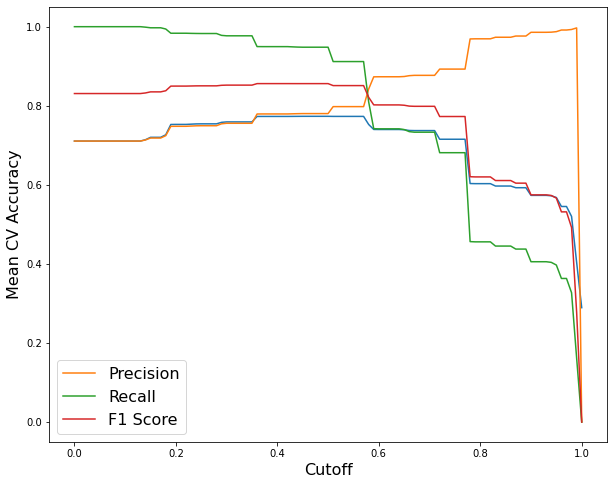

In [38]:
plt.figure(figsize=(10,8))

plt.plot(cutoffs,np.mean(accs,axis=0))
plt.plot(cutoffs,np.mean(precs,axis=0),label="Precision")
plt.plot(cutoffs,np.mean(recs,axis=0),label="Recall")
plt.plot(cutoffs,np.mean(f1s,axis=0),label="F1 Score")


plt.xlabel("Cutoff", fontsize=16)
plt.ylabel("Mean CV Score", fontsize=16)

plt.legend(fontsize=16)


plt.xlabel("Cutoff", fontsize=16)
plt.ylabel("Mean CV Accuracy", fontsize=16)
plt.show()

In [43]:
# Grid search of probabilities

print(codes)
drugs=X_train.drug.unique()
print(drugs)

[70. 75. 76.]
['A' 'B' 'C']


In [63]:
jb = [0,1]

combs = 3*3*8
zc = 0
cl = ['drug','code','CI','CD','TF','approval rate']

pa_df = pd.DataFrame(columns=cl)

for drug in drugs:
    for code in codes:
        for ci in jb: #'contraindication'
            for cd in jb: #correct diagnosis
                for tf in jb: #tried_and_failed
                    dd = X_train[(X_train.drug == drug) & (X_train.reject_code == code) & (X_train.contraindication == ci)
                                   & (X_train.correct_diagnosis == cd) & (X_train.tried_and_failed == tf)]
                    denom = dd.shape[0]
                    if(denom == 0): 
                        #print("No Requests match this combination -- Drug: ", drug, "reject code", code,
                           #  "Contraindication = ",ci,"correct diagnosis =",cd,"Tried and Failed = ",tf)
                        zc = zc+1
                    else:
                        num = dd[dd.pa_approved == 1].shape[0]
                        frac = num/denom
                        print(frac)
                        tmp = pd.DataFrame([[drug,code,ci,cd,tf,frac]],columns=cl)
                        pa_df = pa_df.append(tmp,ignore_index = True)
                        
                        
print(zc,"out of ",combs,"combinations have no PA requests")
        
        

0.502033390410959
0.711311736590547
0.579204224225292
0.7693212185996793
0.14662273476112025
0.31333892617449666
0.18834702806530787
0.36892077223335795
0.9792235047219308
0.9940476190476191
0.9884627710714667
0.9970685232685965
0.8241206030150754
0.9144792548687553
0.8706823925863522
0.9452586206896552
0.5966981132075472
0.8117359413202934
0.6464705882352941
0.8289156626506025
0.13636363636363635
0.35135135135135137
0.2076749435665914
0.43896713615023475
48 out of  72 combinations have no PA requests


In [64]:
pa_df.head(72-48)

,drug,code,CI,CD,TF,approval rate
0,A,70.0,0,0,0,0.502033
1,A,70.0,0,0,1,0.711312
2,A,70.0,0,1,0,0.579204
3,A,70.0,0,1,1,0.769321
4,A,70.0,1,0,0,0.146623
5,A,70.0,1,0,1,0.313339
6,A,70.0,1,1,0,0.188347
7,A,70.0,1,1,1,0.368921
8,B,75.0,0,0,0,0.979224
9,B,75.0,0,0,1,0.994048
